In [103]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

In [104]:
# Set seed
seed = 73
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("GPU: ", torch.cuda.get_device_name(0))

# VGG11
vgg11 = torchvision.models.vgg11(pretrained=True)
vgg11.to(device)
vgg11.eval()


# VGG11 with batch normalization
vgg11_bn = torchvision.models.vgg11_bn(pretrained=True)
vgg11_bn.to(device)
vgg11_bn.eval()

# ResNet18
resnet18 = torchvision.models.resnet18(pretrained=True)
resnet18.to(device)
resnet18.eval()

# ResNet34
resnet34 = torchvision.models.resnet34(pretrained=True)
resnet34.to(device)
resnet34.eval()

# DenseNet121
densenet121 = torchvision.models.densenet121(pretrained=True)
densenet121.to(device)
densenet121.eval()

# MobileNet-v3-Small
mobilenet_v3_small = torchvision.models.mobilenet_v3_small(pretrained=True)
mobilenet_v3_small.to(device)
mobilenet_v3_small.eval()

# Create a list of models
models = [vgg11, vgg11_bn, resnet18, resnet34, densenet121, mobilenet_v3_small]

# Create a list of model names
model_names = ["VGG11", "VGG11 with batch normalization", "ResNet18", "ResNet34", "DenseNet121", "MobileNet-v3-Small"]

# Create a list of top-1 accuracies from https://pytorch.org/vision/stable/models.html
top_1_accuracies = [0.6902, 0.7037, 0.69758, 0.73314, 0.74434, 0.67668]

GPU:  Tesla T4


In [105]:
# Create a fake image
fake_image = torch.rand(1, 3, 224, 224).to(device)

#timing
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
    
# Create a list of inference speeds with torch.grad()
inference_speeds = []
# Create a list of number of parameters
number_of_parameters = []
for model in models:
  start.record()
  for i in range(100):
    with torch.no_grad():
      preds = model(fake_image)
  end.record()
  torch.cuda.synchronize()
  inference_speed = (start.elapsed_time(end) / 100)
  inference_speeds.append(inference_speed)
  number_of_parameters.append(sum(p.numel() for p in model.parameters())/10**6)

  preds.detach()
  del model
  del preds
  torch.cuda.empty_cache()

# Create a list of inference speeds without torch.no_grad()
inference_speeds_without_no_grad = []
for model in models:
  start.record()
  for i in range(100):
    preds = model(fake_image)
  end.record()
  torch.cuda.synchronize()
  inference_speed = (start.elapsed_time(end)/100)
  inference_speeds_without_no_grad.append(inference_speed)

  preds.detach()
  del model
  del preds
  torch.cuda.empty_cache()

# Create a fake image
fake_image = torch.rand(64, 3, 224, 224).to(device)

# Create a list of memory usage with torch.no_grad()
memory_usage_without_no_grad = []
for model in models:
  preds = model(fake_image)
  memory_usage = torch.cuda.memory_allocated() / 2**20
  memory_usage_without_no_grad.append(memory_usage)

  preds.detach()
  del model
  del preds
  torch.cuda.empty_cache()

# Create a list of memory usage without torch.no_grad()
memory_usage_with_no_grad = []
for model in models:
  with torch.no_grad():
    preds = model(fake_image)
  memory_usage_ = torch.cuda.memory_allocated() / 2**20
  memory_usage_with_no_grad.append(memory_usage_)

  preds.detach()
  del model
  del preds
  torch.cuda.empty_cache()


QUESTION: Plot for VGG11, VGG11 with batch normalization, ResNet18,
ResNet34, DenseNet121 and MobileNet-v3-Small, the Top-1 accuracy on ImageNet
vs the inference speed. The value for the Top-1 accuracy of each model can be
found on the PyTorch website. Also plot the inference speed vs the number
of parameters. Does it scale proportionately? 
Make sure to set the model on evaluation mode, use ```torch.no_grad()``` and a GPU. Report the inference speed in ms for one image. Average the inference speed across multiple forward passes. Shortly, describe the trends you observe.

\
Top-1 accuracy on ImageNet vs the inference speed
- RestNet34 seems to be the best choice with the best Top-1 accuracy and the second-fastest inference speed.
- DenseNet121 is the slowest model. It could be the slowest one because it is the deepest model.

\

Inference speed vs the number of parameters

- It looks like the number of parameters does not scale proportionately.
- The inference speed does not vary much for the number of parameters, it looks like the difference in the number of parameters does not affect the inference speed. Except for DenseNet121, which has a low number of parameters and high inference speed.




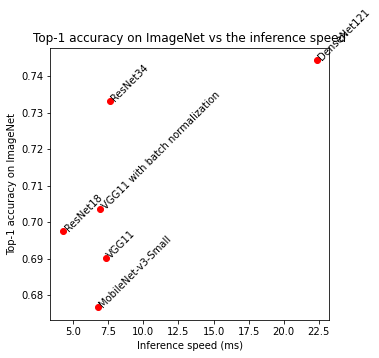

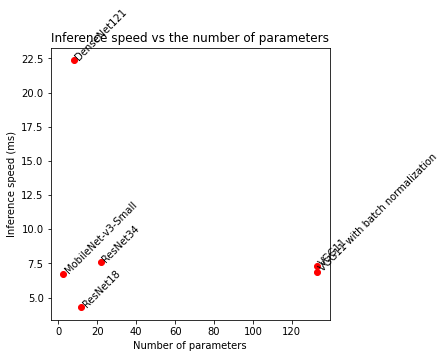

In [106]:
# Plot the Top-1 accuracy on ImageNet vs the inference speed
plt.figure(figsize=(5, 5))
plt.plot(inference_speeds,top_1_accuracies, 'ro')
plt.ylabel('Top-1 accuracy on ImageNet')
plt.xlabel('Inference speed (ms)')
plt.title('Top-1 accuracy on ImageNet vs the inference speed')
for i,  model in enumerate(model_names):
    plt.annotate(model, xy=(inference_speeds[i],
                            top_1_accuracies[i]),
                  xytext=(inference_speeds[i],
                            top_1_accuracies[i]),
                  ha='left', rotation=45)
plt.show()

# Plot the inference speed vs the number of parameters
plt.figure(figsize=(5,5))
plt.plot(number_of_parameters, inference_speeds, 'ro')
plt.xlabel('Number of parameters')
plt.ylabel('Inference speed (ms)')
plt.title('Inference speed vs the number of parameters')
for i,  model in enumerate(model_names):
    plt.annotate(model, xy=(number_of_parameters[i],
                            inference_speeds[i]),
                  xytext=(number_of_parameters[i],
                          inference_speeds[i]), ha='left', rotation=45)
plt.show()


Do you expect the inference speed to increase or decrease without ```torch.no_grad()```? Why? What does ```torch.no_grad()``` do? For the same
models as in (a), plot the inference speed with and without ```torch.no_grad()```.

\

- Speed inference should increase without ```torch.no_grad()```, becuase ```torch.no_grad()``` deactivates autograd engine. With this, ```torch.no_grad()``` will reduce the memory usage and speed up computations. In the plot, we can see that in general without ```torch.no_grad()``` the inference speed is higher.

\

For the same models as in (a), plot the amount of GPU vRAM (you
can check this with code by executing ```torch.cuda.memory_allocated()```
or with the terminal using nvidia-smi) while conducting a forward pass
with ```torch.no_grad()``` and without. Does ```torch.no_grad()``` influence the
memory usage? Why? Make sure to save the output after the forward pass. Use```batch_size=64``` and report the memory in MB.

\

- Yes, since without ```torch.no_grad()``` the gradients are computed and stored in memory, so memory will be afected as seen in the plot.

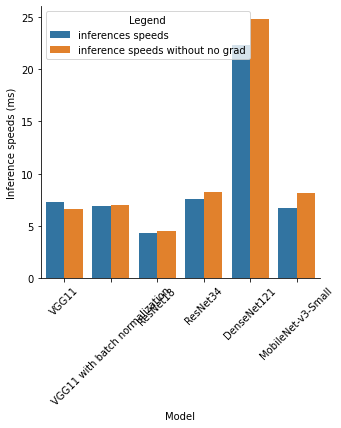

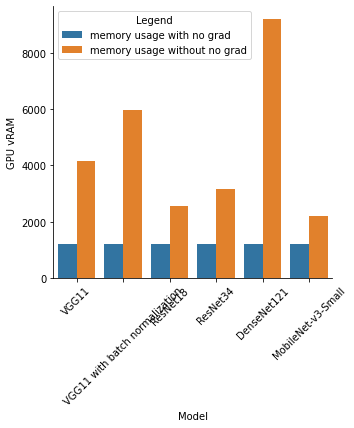

In [107]:
speeds_dict = {'model': model_names, 'inferences speeds': inference_speeds,
               'inference speeds without no grad': inference_speeds_without_no_grad}
speeds_df = pd.DataFrame(speeds_dict)
fig, ax1 = plt.subplots(figsize=(5,5))
tidy = speeds_df.melt(id_vars='model').rename(columns=str.title)
tidy.columns = ['Model','Legend','Inference speeds (ms)']
sns.barplot(x='Model', y='Inference speeds (ms)', hue='Legend', data=tidy, ax=ax1)
plt.xticks(rotation=45)
sns.despine(fig)



memory_dict = {'model': model_names,
               'memory usage with no grad': memory_usage_with_no_grad,
               'memory usage without no grad': memory_usage_without_no_grad}
memory_df = pd.DataFrame(memory_dict)
fig2, ax2 = plt.subplots(figsize=(5,5))
tidy2 = memory_df.melt(id_vars='model').rename(columns=str.title)
tidy2.columns = ['Model','Legend','GPU vRAM']
sns.barplot(x='Model', y='GPU vRAM', hue='Legend', data=tidy2, ax=ax2)
plt.xticks(rotation=45)
sns.despine(fig2)
